# **Aprendizaje supervisado**
# SL08. M√°quinas de Soporte Vectorial (SVM)

## <font color='blue'>**M√°quinas de Soporte Vectorial (SVM)**</font>


Las **m√°quinas de soporte vectorial (SVM)** son una clase particularmente poderosa y flexible de **algoritmos supervisados** tanto para clasificaci√≥n como para regresi√≥n.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

SVM corresponde a un tipo de clasificaci√≥n **discriminativa**, que es la que busca modelar cada clase, encontrando una l√≠nea o curva (en dos dimensiones) o un plano (en N-dimensiones) que divide las clases entre s√≠.

Como ejemplo de esto, considere el caso simple de una tarea de clasificaci√≥n, en la que las dos clases de puntos est√°n bien separadas:

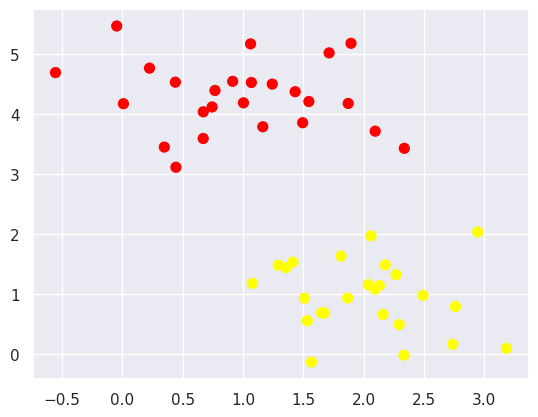

In [45]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

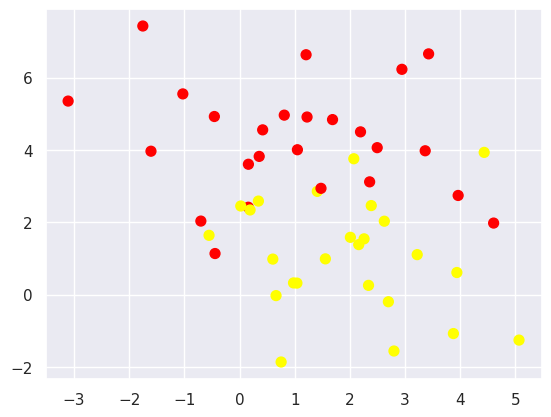

In [46]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=1.6) # Modificamos cluster_std
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

Un clasificador discriminativo lineal intentar√≠a trazar una l√≠nea recta que separe los dos conjuntos de datos y, por lo tanto, crear√≠a un modelo de clasificaci√≥n. Para datos bidimensionales como el que se muestra aqu√≠, esta es una tarea que podr√≠amos hacer a mano. Pero inmediatamente vemos un problema: **¬°hay m√°s de una posible l√≠nea divisoria que puede discriminar perfectamente entre las dos clases!**

Podemos dibujarlos de la siguiente manera:

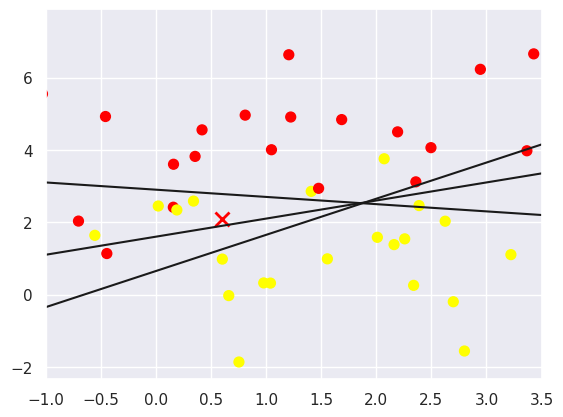

In [47]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.show()

Se trata de tres separadores muy diferentes que, sin embargo, discriminan perfectamente entre estas muestras. Dependiendo de cu√°l se elija, a un nuevo punto de datos (por ejemplo, el marcado con la "X" en este gr√°fico) se le asignar√° una etiqueta diferente. Evidentemente, nuestra simple intuici√≥n de "trazar una l√≠nea divisoria entre clases" no es suficiente, y necesitamos pensar un poco m√°s.

## Maximizando el *Margen*

Las m√°quinas de soporte vectorial ofrecen una forma mejorada de solucionar este problema.

La idea es la siguiente: en lugar de simplemente dibujar una l√≠nea de ancho cero entre las clases, podemos dibujar alrededor de cada l√≠nea un margen de cierto ancho, hasta el punto m√°s cercano. A continuaci√≥n, se muestra un ejemplo de c√≥mo podr√≠a verse esto:

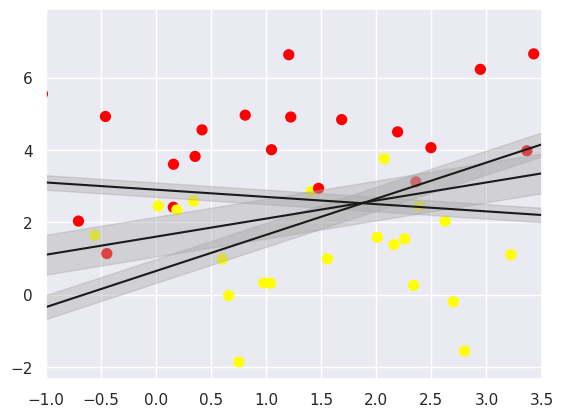

In [48]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)
plt.show()

En las SVM, la l√≠nea que **maximiza este margen** es la que elegiremos como modelo √≥ptimo. Las SVM son un ejemplo de estimador de margen m√°ximo.

## Ajuste de una m√°quina de vectores de soporte

Veamos el resultado de un ajuste real a los datos del ejemplo: utilizaremos el clasificador de vectores de soporte de Scikit-Learn para entrenar un modelo SVM sobre estos datos. Por el momento, usaremos un kernel lineal y estableceremos el par√°metro C en un n√∫mero muy grande (discutiremos el significado de estos con m√°s profundidad moment√°neamente).

In [49]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=100000) # parametro de regularizaci√≥n, es la penalizaci√≥n de las equivocaciones
model.fit(X, y)

SVC(C=100000, kernel='linear')

Para visualizar mejor lo que est√° sucediendo aqu√≠, creemos una funci√≥n que permita trazar los l√≠mites de decisi√≥n del SVM:

In [50]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

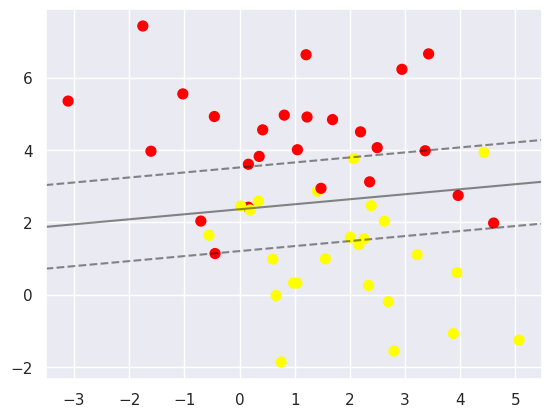

In [51]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)
plt.show()


Esta es la **l√≠nea divisoria que maximiza el margen entre los dos conjuntos de puntos**. Observe que algunos de los puntos de entrenamiento solo tocan el margen. Estos puntos son los elementos fundamentales de este ajuste y se conocen como vectores de soporte, y dan nombre al algoritmo. En Scikit-Learn, los valores de estos puntos se almacenan en el atributo *support_vectors_* del clasificador:

In [52]:
model.support_vectors_

array([[ 3.3667966 ,  3.97553411],
       [ 2.359368  ,  3.11632329],
       [ 1.4771784 ,  2.93723414],
       [-0.44418712,  1.13451298],
       [ 4.60787748,  1.97680225],
       [ 0.16082659,  3.60286844],
       [ 3.96436286,  2.74014272],
       [ 0.15898186,  2.41477583],
       [ 1.04948371,  4.00429317],
       [-0.70141467,  2.03175863],
       [ 0.34206333,  2.58478642],
       [ 1.41018441,  2.85357577],
       [ 2.07206755,  3.75505645],
       [ 2.62545376,  2.02818073],
       [ 2.38850749,  2.46028612],
       [ 2.25832687,  1.54084664],
       [-0.55304983,  1.63811527],
       [ 0.19102778,  2.33898604],
       [ 0.02249152,  2.44869839],
       [ 4.43647103,  3.93108634]])

Una clave del √©xito de este clasificador es que para el ajuste, solo importa la posici√≥n de los vectores de soporte; ¬°Cualquier punto m√°s alejado del margen que est√© en el lado correcto no modifica el ajuste! T√©cnicamente, esto se debe a que estos puntos no contribuyen a la funci√≥n de p√©rdida utilizada para ajustar el modelo, por lo que su posici√≥n y n√∫mero no importan siempre que no crucen el margen.

Podemos ver esto, por ejemplo, si graficamos el modelo entrenado con los primeros 60 puntos y luego con los primeros 120 puntos de este conjunto de datos:

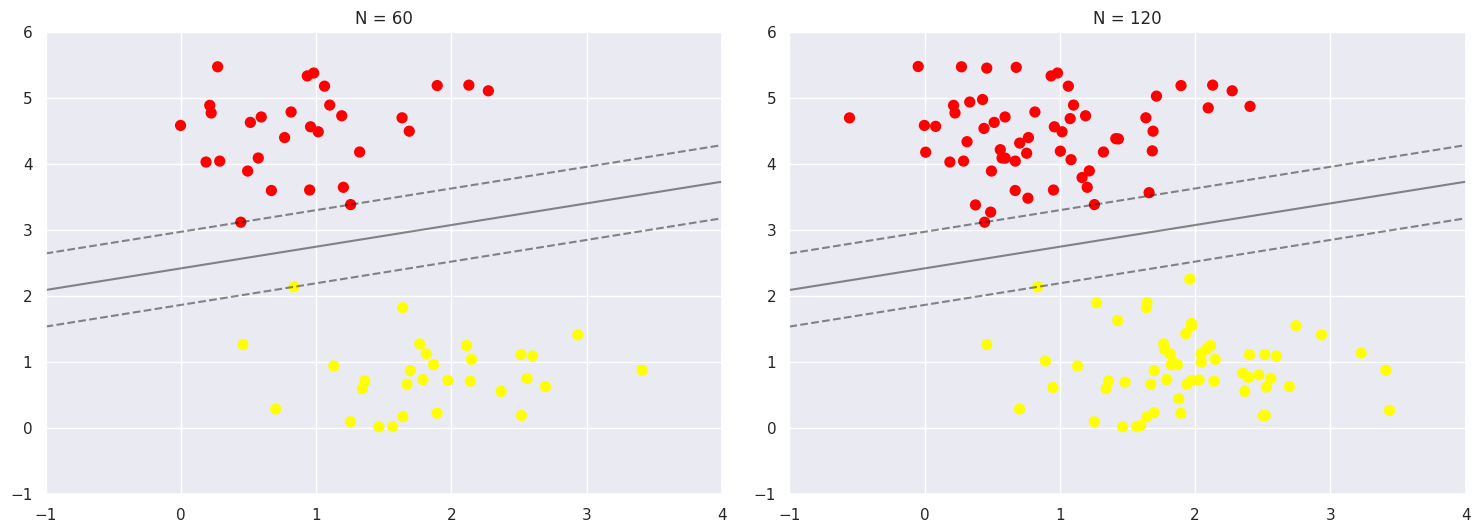

In [53]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

En el gr√°fico de la izquierda vemos el modelo y los vectores de soporte para 60 puntos de entrenamiento. En el gr√°fico de la derecha, hemos duplicado el n√∫mero de puntos de entrenamiento, pero el modelo no ha cambiado: los tres vectores de soporte del gr√°fico izquierdo siguen siendo los vectores de soporte del gr√°fico derecho. Esta insensibilidad al comportamiento exacto de los puntos distantes es uno de los puntos fuertes del modelo SVM.

In [54]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 200, 1000], ax=fixed(None))
plt.show()

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 200, 1000), value=10), Output()), _dom_c‚Ä¶

## <font color='green'>Actividad 1</font>

Entrene una SVM para clasificar correctamente los siguientes datos:

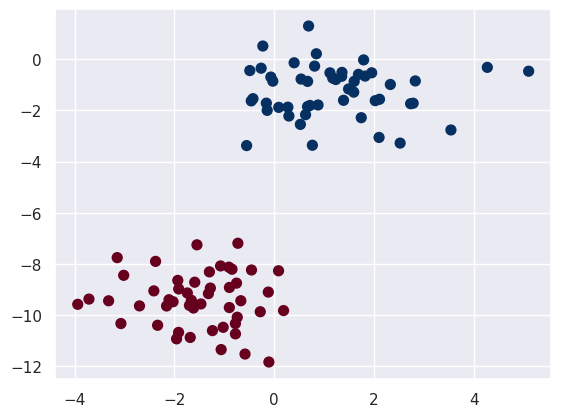

In [55]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plt.show()

Ajuste la SVM con un kernel lineal.

In [56]:
# T√∫ codigo aqu√≠ ...
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1000) # parametro de regularizaci√≥n, es la penalizaci√≥n de las equivocaciones
model.fit(X, y)


SVC(C=1000, kernel='linear')

Grafique los puntos y el plano separador.

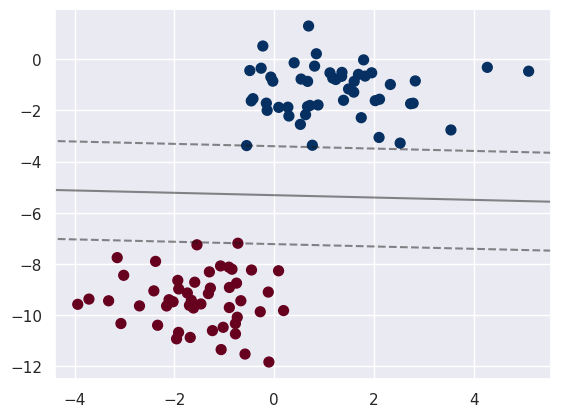

In [57]:
# T√∫ codigo aqu√≠ ...
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plot_svc_decision_function(model)
plt.show()

<font color='green'>Fin Actividad 1</font>

### Kernel SVM

SVM se vuelve extremadamente poderoso cuando se combina con **kernels**.

La manera m√°s simple de realizar la separaci√≥n es mediante una l√≠nea recta, un plano o un hiperplano N-dimensional.

Desafortunadamente los universos a estudiar no se suelen presentar en casos id√≠licos de dos dimensiones como en el ejemplo anterior, sino que un algoritmo SVM debe tratar con a) m√°s de dos variables predictoras, b) curvas no lineales de separaci√≥n, c) casos donde los conjuntos de datos no pueden ser completamente separados, d) clasificaciones en m√°s de dos categor√≠as.

Debido a las limitaciones computacionales de las m√°quinas de aprendizaje lineal, √©stas no pueden ser utilizadas en la mayor√≠a de las aplicaciones del mundo real. **La representaci√≥n por medio de funciones Kernel ofrece una soluci√≥n a este problema**, proyectando la informaci√≥n a un espacio de caracter√≠sticas de mayor dimensi√≥n el cual aumenta la capacidad computacional de la m√°quinas de aprendizaje lineal. Es decir, **mapearemos el espacio de entradas X a un nuevo espacio de caracter√≠sticas de mayor dimensionalidad (espacio de Hilbert)**:

Para motivar la necesidad de kernels, veamos algunos datos que no se pueden separar linealmente:

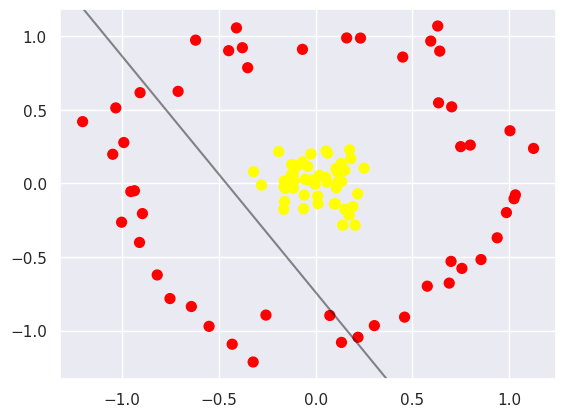

In [58]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)
plt.show()

Est√° claro que ninguna discriminaci√≥n lineal podr√° separar estos datos. La soluci√≥n es proyectar los datos en una dimensi√≥n superior de modo que un separador lineal sea suficiente. Por ejemplo, una proyecci√≥n simple que podr√≠amos usar ser√≠a calcular una funci√≥n de base radial centrada en el grupo del medio:

In [59]:
# Transformamos los datos, elev√°ndolos al cuadrado
# A esto se
r = np.exp(-(X ** 2).sum(1))

In [60]:
# Veamos la transformaci√≥n en los 10 primeros elementos
X[:10]

array([[-0.4306748 , -1.09191281],
       [-0.09388944,  0.12022215],
       [-0.90930607, -0.40082437],
       [-0.4489252 ,  0.90179374],
       [ 0.01124234, -0.08655372],
       [ 0.23208157,  0.98739482],
       [ 1.03212615, -0.07756956],
       [-1.0019581 , -0.26323184],
       [-0.2795013 , -0.01131428],
       [-0.11556259,  0.06304335]])

In [61]:
X[:10] ** 2

array([[1.85480784e-01, 1.19227358e+00],
       [8.81522754e-03, 1.44533652e-02],
       [8.26837522e-01, 1.60660176e-01],
       [2.01533838e-01, 8.13231948e-01],
       [1.26390164e-04, 7.49154620e-03],
       [5.38618542e-02, 9.74948528e-01],
       [1.06528440e+00, 6.01703738e-03],
       [1.00392003e+00, 6.92910021e-02],
       [7.81209774e-02, 1.28012938e-04],
       [1.33547112e-02, 3.97446419e-03]])

In [62]:
(X[:10] ** 2).sum(1)

array([1.37775436, 0.02326859, 0.9874977 , 1.01476579, 0.00761794,
       1.02881038, 1.07130143, 1.07321103, 0.07824899, 0.01732918])

In [63]:
# Ac√° la transformaci√≥n exponencial
np.exp(-(X[:10] ** 2).sum(1))

array([0.25214414, 0.97700003, 0.37250765, 0.36248732, 0.99241101,
       0.35743192, 0.3425624 , 0.34190887, 0.92473415, 0.98282011])

In [64]:
r[:10]

array([0.25214414, 0.97700003, 0.37250765, 0.36248732, 0.99241101,
       0.35743192, 0.3425624 , 0.34190887, 0.92473415, 0.98282011])

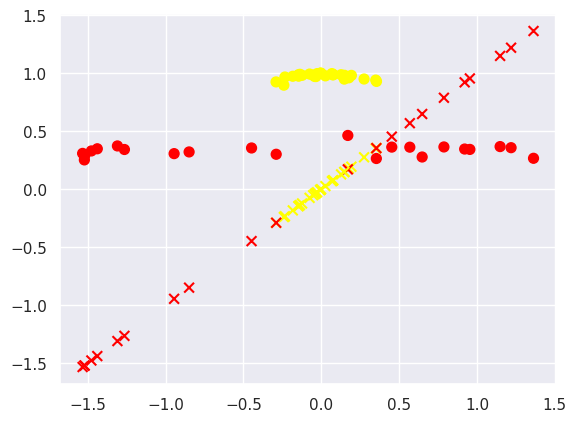

In [65]:
plt.scatter(X[:50].sum(1), r[:50], c=y[:50], cmap='autumn', s=50)
plt.scatter(X[:50].sum(1), X[:50].sum(1), c=y[:50], cmap='autumn', s=50, marker='x')
plt.show()

El gr√°fico 2D muestra dos conjuntos de puntos diferenciados por sus marcadores y colores. Los puntos circulares, coloreados seg√∫n la clase con cmap='autumn', representan los datos transformados, donde el eje $X$ es la suma de sus coordenadas originales $(X_1 + X_2)$ y el eje $Y$ es la transformaci√≥n $r = \exp(-\|X\|^2)$, que ajusta los valores seg√∫n su distancia al origen. Por otro lado, los puntos en forma de ‚Äúx‚Äù, con los mismos colores, representan los datos sin transformar y se ubican en la diagonal $(x = y)$ como referencia. Esta visualizaci√≥n permite comparar la distribuci√≥n de los datos antes y despu√©s de la transformaci√≥n, destacando c√≥mo esta ayuda a separar mejor las clases.

Podemos visualizar esta dimensi√≥n de datos adicional utilizando un gr√°fico tridimensional:

In [66]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 30, -60, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y))
plt.show()

interactive(children=(Dropdown(description='elev', index=1, options=(-90, 30, -60, 90), value=30), IntSlider(v‚Ä¶

Podemos ver que con esta dimensi√≥n adicional, los datos se vuelven trivialmente separables linealmente, dibujando un plano de separaci√≥n en, digamos, r = 0,7.

Aqu√≠ tuvimos que elegir y ajustar cuidadosamente nuestra proyecci√≥n: si no hubi√©ramos centrado nuestra funci√≥n de base radial en la ubicaci√≥n correcta, no hubi√©ramos visto resultados tan limpios y linealmente separables. En general, la necesidad de hacer tal elecci√≥n es un problema: nos gustar√≠a de alguna manera encontrar autom√°ticamente las mejores funciones de base para usar.

Una estrategia para este fin es calcular una funci√≥n base centrada en cada punto del conjunto de datos y dejar que el algoritmo SVM revise los resultados. Este tipo de transformaci√≥n de funci√≥n de base se conoce como transformaci√≥n de kernel, ya que se basa en una relaci√≥n de similitud (o kernel) entre cada par de puntos.

Un problema potencial con esta estrategia, proyectar ùëÅ puntos en ùëÅ dimensiones, es que puede volverse muy intensiva en computaci√≥n a medida que ùëÅ crece. Sin embargo, debido a un peque√±o y prolijo procedimiento conocido como el truco del kernel, se puede hacer un ajuste en los datos transformados del kernel de forma impl√≠cita, es decir, ¬°sin construir la representaci√≥n ùëÅ-dimensional completa de la proyecci√≥n del kernel! Este truco del kernel est√° integrado en SVM y es una de las razones por las que el m√©todo es tan poderoso.

En Scikit-Learn, podemos aplicar SVM kernelizado simplemente cambiando nuestro kernel lineal a un kernel RBF (funci√≥n de base radial), usando el hiperpar√°metro del modelo de kernel:

In [67]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

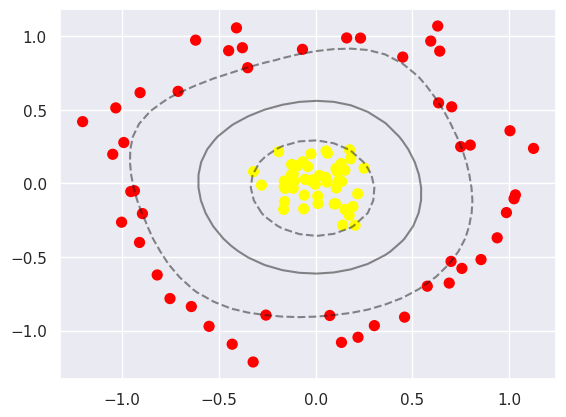

In [68]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Usando esta SVM kernelizada, el modelo es capaz de determinar un l√≠mite de decisi√≥n no lineal adecuado. Esta estrategia de transformaci√≥n del kernel se usa a menudo en el aprendizaje autom√°tico para convertir m√©todos lineales r√°pidos en m√©todos no lineales r√°pidos, especialmente para modelos en los que se puede usar el truco del kernel.

### Tuning de SVM

Hasta ahora, nuestra discusi√≥n se ha centrado en conjuntos de datos muy limpios, en los que existe un l√≠mite de decisi√≥n perfecto. Pero, ¬øqu√© pasa si sus datos tienen cierta superposici√≥n? Por ejemplo, puede tener datos como este:

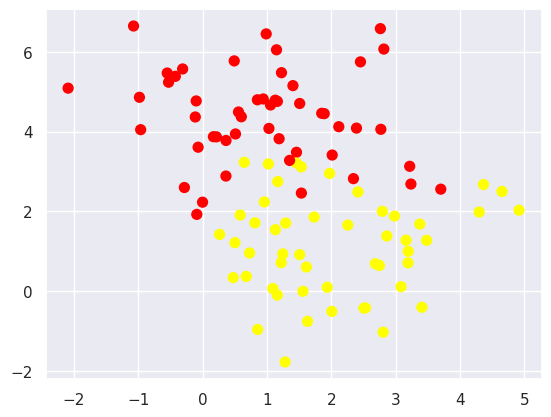

In [69]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

Para manejar este caso, la implementaci√≥n de SVM tiene un peque√±o factor de modificaci√≥n que "suaviza" el margen: es decir, permite que algunos de los puntos se introduzcan en el margen si eso permite un mejor ajuste. La "rigidez" del margen se controla mediante un par√°metro de ajuste, m√°s a menudo conocido como ùê∂ (regularizaci√≥n). Para ùê∂ muy grande, el margen es m√°s estricto y los puntos no pueden estar en √©l. Para ùê∂ m√°s peque√±o, el margen es m√°s suave y puede crecer para abarcar algunos puntos.

El gr√°fico que se muestra a continuaci√≥n ofrece una imagen visual de c√≥mo un par√°metro ùê∂ cambiante afecta el ajuste final, a trav√©s de la regularizaci√≥n del margen:

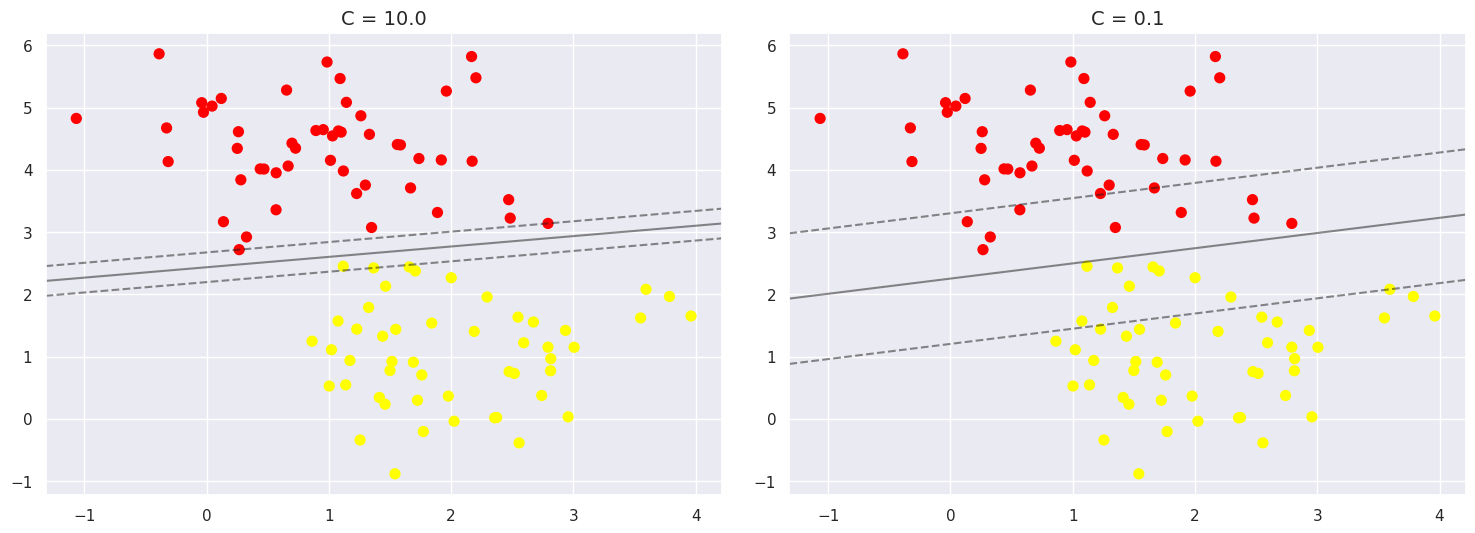

In [70]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)
plt.show()

El valor √≥ptimo del par√°metro ùê∂ depender√° de su conjunto de datos y debe ajustarse mediante validaci√≥n cruzada o un procedimiento similar.

## <font color='green'>Actividad 2</font>

Genere un modelo de SVM con kernel RBF, grafique el resultado y muestre el limite de decisi√≥n y su margen.

Utilice los siguientes datos:

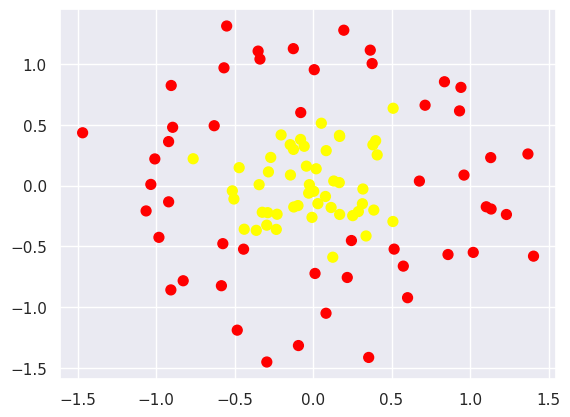

In [71]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.3, noise=.2)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

In [72]:
# T√∫ codigo aqu√≠ ...
clf = SVC(kernel='rbf', C=1e8)
clf.fit(X, y)


SVC(C=100000000.0)

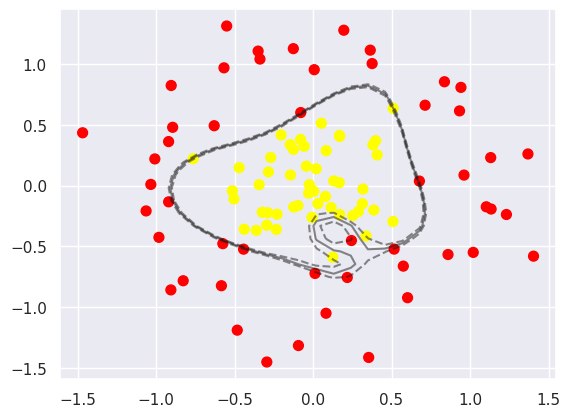

In [73]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

<font color='green'>Fin Actividad 2</font>

## <font color='blue'>**Ejemplo: Face Recognition**</font>

Cuando SVM surgi√≥ en la d√©cada de 1990, supuso un avance importante en clasificaci√≥n de im√°genes y otros problemas de machine learning por varias razones:
1. Manejo eficiente de datos en alta dimensi√≥n ‚Üí Las im√°genes suelen tener miles o millones de p√≠xeles, y SVM pod√≠a trabajar con estas dimensiones sin problemas de overfitting.
2. Capacidad para modelar relaciones no lineales ‚Üí Gracias a los kernels, SVM pod√≠a clasificar im√°genes sin requerir transformaciones manuales complejas.
3. Buena generalizaci√≥n ‚Üí SVM usa el margen m√°ximo para encontrar la mejor separaci√≥n entre clases, reduciendo el riesgo de sobreajuste.
4. Menos dependencia de grandes vol√∫menes de datos ‚Üí En comparaci√≥n con redes neuronales, SVM pod√≠a funcionar bien con conjuntos de datos relativamente peque√±os, lo cual era √∫til cuando los datos de entrenamiento eran limitados.

SVM fue ampliamente utilizado en reconocimiento facial, detecci√≥n de objetos y clasificaci√≥n de im√°genes biom√©dicas, antes de la era del aprendizaje profundo.

Como ejemplo de aplicaci√≥n de SVM, tenemos el problema del reconocimiento facial. Usaremos el conjunto de datos *Labeled Faces in the Wild dataset*, que consta de varios miles de fotos recopiladas de varias figuras p√∫blicas. Un buscador para el conjunto de datos est√° integrado en Scikit-Learn:

In [74]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


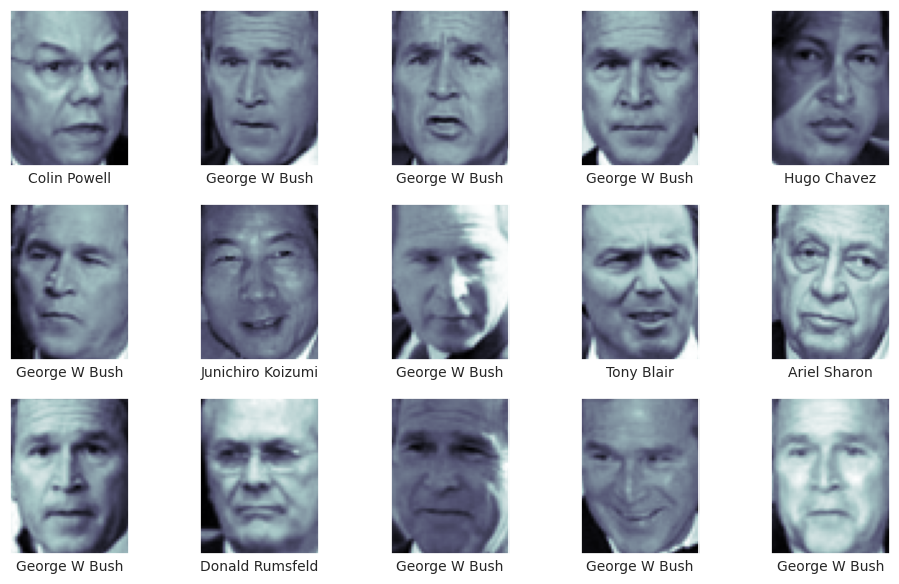

In [75]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))  # Ajustamos el tama√±o de la figura
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[])  # Eliminamos los ejes
    axi.set_xlabel(faces.target_names[faces.target[i]], fontsize=10)  # Reducimos el tama√±o de fuente

plt.tight_layout()
plt.show()

Cada imagen es de (62 √ó 47) p√≠xeles. Podr√≠amos proceder simplemente usando cada valor de p√≠xel como una caracter√≠stica, pero a menudo es m√°s efectivo usar alg√∫n tipo de preprocesador para extraer caracter√≠sticas m√°s significativas; aqu√≠ usaremos un an√°lisis de componentes principales para extraer 150 componentes fundamentales para alimentar a nuestro clasificador SVM.

In [76]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Tomamos las im√°genes, las aplanamos a vectores de 62 x 47 = 2.914
# Aplicamos PCA para elegir las, por ejemplo, 150 con mayor informaci√≥n
pca = PCA(n_components=150, whiten=True, random_state=42)
#svc = SVC(kernel='rbf', class_weight='balanced') # Por defecto entrena en modo One-vs-One (OvO) para manejar la multiclase
svc = SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovr') # modo One-vs-All (OvA)
model = make_pipeline(pca, svc)

In [77]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [78]:
faces.target

array([1, 3, 3, ..., 7, 3, 5])

In [79]:
faces.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')

In [80]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

# Grid search nos ayuda a probar con distintos par√°metros
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 2min 33s, sys: 322 ms, total: 2min 33s
Wall time: 1min 31s
{'svc__C': 5, 'svc__gamma': 0.001}


In [81]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

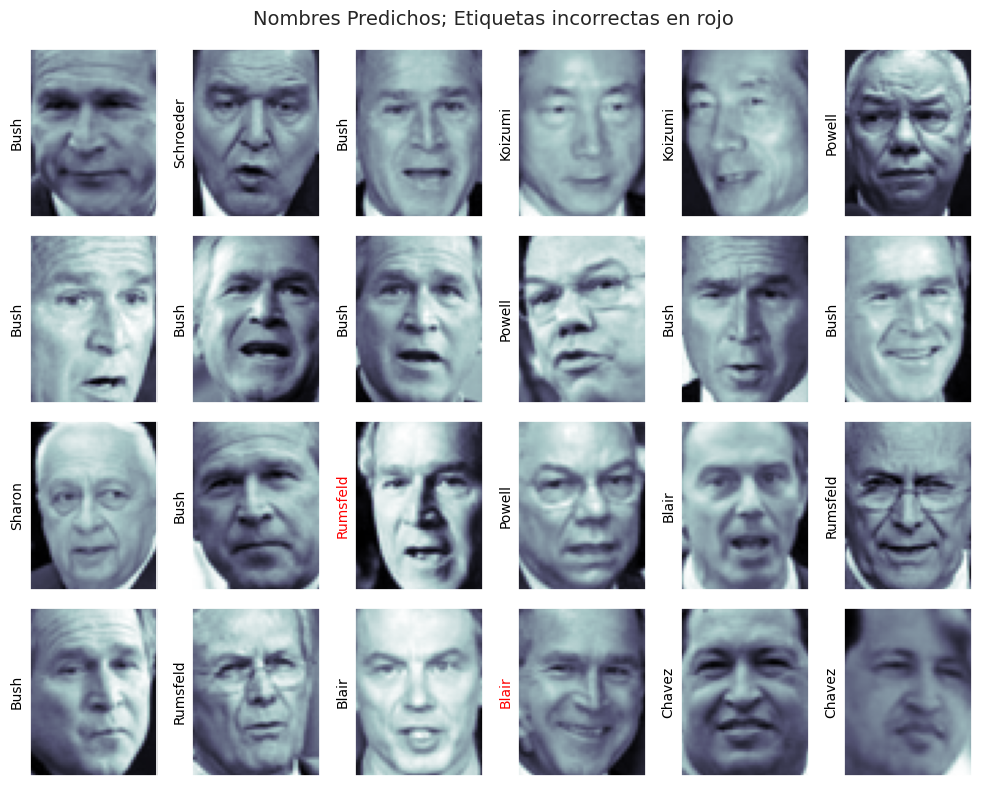

In [82]:
fig, ax = plt.subplots(4, 6, figsize=(10, 8))  # Ajusta el tama√±o de la figura para mayor claridad

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])  # Elimina marcas en los ejes
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red', fontsize=10)  # Reduce el tama√±o de la fuente

fig.suptitle('Nombres Predichos; Etiquetas incorrectas en rojo', fontsize=14)  # Ajusta tama√±o de t√≠tulo
plt.tight_layout()  # Mejora el espaciado entre subgr√°ficos
plt.show()

In [83]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



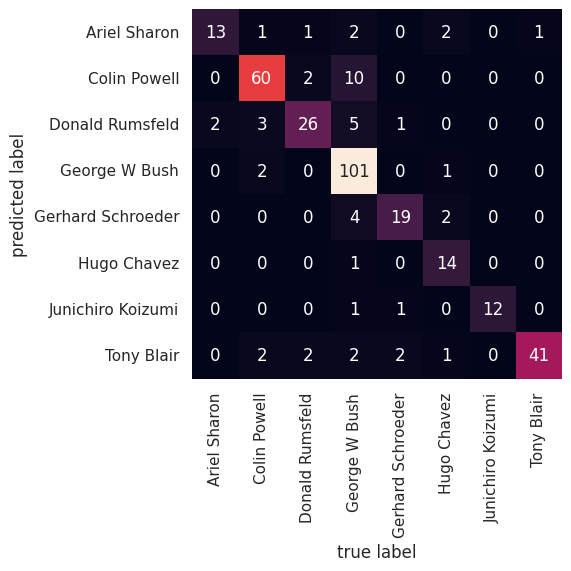

In [84]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## <font color='blue'>**Resumen de las SVM**</font>

Este m√©todo de clasificaci√≥n es muy poderoso por varias razones:

* Su dependencia de relativamente pocos vectores de soporte significa que son modelos muy compactos y ocupan muy poca memoria.

* Una vez que se entrena el modelo, la fase de predicci√≥n es muy r√°pida.

* Debido a que solo se ven afectados por puntos cercanos al margen, funcionan bien con datos de alta dimensi√≥n, incluso datos con m√°s dimensiones que muestras.

* Su integraci√≥n con los m√©todos del kernel los hace muy vers√°tiles, capaces de adaptarse a muchos tipos de datos.

Sin embargo, las SVM tambi√©n tienen varias desventajas:

* La escala con el n√∫mero de muestras ùëÅ es $O[ùëÅ^{3}]$ en el peor de los casos, o $O[ùëÅ^{2}]$ para implementaciones eficientes. Para un gran n√∫mero de muestras, el costo computacional puede resultar prohibitivo.

* Los resultados dependen en gran medida de una elecci√≥n adecuada para el par√°metro de regularizaci√≥n ùê∂. Este debe elegirse cuidadosamente a trav√©s de la validaci√≥n cruzada, que puede ser costosa a medida que los conjuntos de datos aumentan de tama√±o.

* Los resultados no tienen una interpretaci√≥n probabil√≠stica directa. Esto se puede estimar mediante una validaci√≥n cruzada interna, pero esta estimaci√≥n adicional es costosa.